# XGB RF: first run
Total dataset size: 127 samples <br>
Training set: 95 samples <br>
Testing set: 32 samples

Features used:
- LTA precipitation (mmpa)
- LTA WD (days)
- LTA PET (mm)
- Aridity idx
- LTA NDVI idx
- LTA soil moisture - 10cm (kgm-2)
- Aquifer group (cat.)
- Soil group (cat.)
- Landcover (cat.)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
import xgboost as xgb

# read file (data + coordinates)
file = pd.read_csv('poc.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa'] < 800]

# extract data only for one-hot encoding
data = file.drop(columns=['Lat', 'Long', 'ID', 'LTA_WD_days','Landcover'])
data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_ext,DEM,SM10_m3m3,SM10_kgm2
0,253.0,1234.743356,1265.000000,0.977426,0.548899,Basement,LX,130,360,0.317942,23.815275
1,22.0,555.876675,1386.030028,0.403442,0.417538,Basement,AC,30,1039,0.210401,17.259396
2,245.0,1376.716688,1337.440024,1.029575,0.687945,Basement,NT,30,1125,0.312940,26.114550
3,185.0,518.196676,1590.610029,0.326188,0.268559,Sedimentary,LP,200,1657,0.229384,19.132140
4,120.0,1344.580024,1298.693353,1.038857,0.593882,Sedimentary,NT,30,26,0.330358,25.831575
...,...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,Sedimentary,LP,30,1376,0.323871,22.159473
130,80.0,816.720013,1266.233355,0.648767,0.479056,Basement,CM,130,1382,0.227937,19.953318
131,8.0,510.140009,1922.536704,0.265403,0.327490,Unconsolidated,GL,14,28,0.194245,11.226820
132,160.0,1215.073356,1149.026683,1.058098,0.447078,Sedimentary,LP,20,2482,0.279276,29.116320


In [3]:
# One-hot encode the data using pandas get_dummies
# TODO: use Label Encoder instead and check if the model performs better
# https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
#data = pd.get_dummies(data)
labelencoder = LabelEncoder()
data['Aquifer_group_cat'] = labelencoder.fit_transform(data['Aquifer_group'])
data['Soil_group_cat'] = labelencoder.fit_transform(data['Soil_group'])
# data['Landcover_cat'] = labelencoder.fit_transform(data['Landcover'])

# # remove categorical variables
data = data.drop('Aquifer_group', axis = 1)
data = data.drop('Soil_group', axis = 1)
# data = data.drop('Landcover', axis = 1)

data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Landcover_ext,DEM,SM10_m3m3,SM10_kgm2,Aquifer_group_cat,Soil_group_cat
0,253.0,1234.743356,1265.000000,0.977426,0.548899,130,360,0.317942,23.815275,0,12
1,22.0,555.876675,1386.030028,0.403442,0.417538,30,1039,0.210401,17.259396,0,0
2,245.0,1376.716688,1337.440024,1.029575,0.687945,30,1125,0.312940,26.114550,0,13
3,185.0,518.196676,1590.610029,0.326188,0.268559,200,1657,0.229384,19.132140,1,10
4,120.0,1344.580024,1298.693353,1.038857,0.593882,30,26,0.330358,25.831575,1,13
...,...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,30,1376,0.323871,22.159473,1,10
130,80.0,816.720013,1266.233355,0.648767,0.479056,130,1382,0.227937,19.953318,0,4
131,8.0,510.140009,1922.536704,0.265403,0.327490,14,28,0.194245,11.226820,2,8
132,160.0,1215.073356,1149.026683,1.058098,0.447078,20,2482,0.279276,29.116320,1,10


In [4]:
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
# Remove the labels from the features
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

Text(0, 0.5, 'Number of observations')

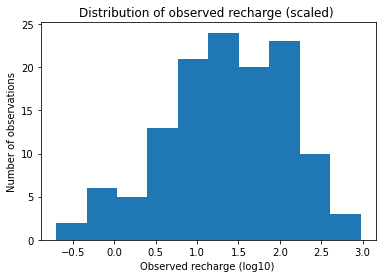

In [5]:
n_bins = 10

fig, axs = plt.subplots(1,1)

# We can set the number of bins with the `bins` kwarg
axs.hist(labels, bins=n_bins)
axs.set_title('Distribution of observed recharge (scaled) ')
axs.set_xlabel('Observed recharge (log10) ')
axs.set_ylabel('Number of observations')

In [6]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [6]:
# import numpy as np
# # "Learn" the mean from the training data
# mean_train = np.mean(train_labels)
# print(f'Mean train: {mean_train}')
# # Get predictions on the test set
# baseline_predictions = np.ones(test_labels.shape) * mean_train
# # Compute MAE
# mae_baseline = metrics.mean_absolute_error(test_labels, baseline_predictions)
# print("Baseline MAE is {:.2f}".format(mae_baseline))

Mean train: 1.2881069374108811
Baseline MAE is 0.61


In [7]:
# # evaluate xgboost random forest ensemble for regression
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_regression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from xgboost import XGBRFRegressor
# # define the model
# model = XGBRFRegressor(n_estimators=100, subsample=0.9, colsample_bynode=0.2)
# # define the model evaluation procedure
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # evaluate the model and collect the scores
# n_scores = cross_val_score(model, train_features[:,:-1], train_labels, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# # report performance
# print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [8]:
# # XGB hyperparam tuning

# # (1): find optimal num_boost_round
# dtrain = xgb.DMatrix(train_features[:,:-1], label=train_labels)
# dtest = xgb.DMatrix(test_features[:,:-1], label=test_labels)

# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':'reg:squarederror',
# }
# params['eval_metric'] = "mae"
# num_boost_round = 999

# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )

# print("Best MAE: {:.2f} with {} rounds".format(
#                  model.best_score,
#                  model.best_iteration+1))

[0]	Test-mae:0.87638
[1]	Test-mae:0.73254
[2]	Test-mae:0.62796
[3]	Test-mae:0.53634
[4]	Test-mae:0.48322
[5]	Test-mae:0.45036
[6]	Test-mae:0.43472
[7]	Test-mae:0.42695
[8]	Test-mae:0.41646
[9]	Test-mae:0.41845
[10]	Test-mae:0.42128
[11]	Test-mae:0.41982
[12]	Test-mae:0.41904
[13]	Test-mae:0.41931
[14]	Test-mae:0.41970
[15]	Test-mae:0.41882
[16]	Test-mae:0.41739
[17]	Test-mae:0.41841
Best MAE: 0.42 with 9 rounds


In [7]:
# #(2): find other hyperparams using cross-validation

# # You can try wider intervals with a larger step between
# # each value and then narrow it down. Here after several
# # iteration I found that the optimal value was in the
# # following ranges.
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in np.arange(0,4)
#     for min_child_weight in np.arange(4,7, 0.2)
# ]

# # Define initial best params and MAE
# min_mae = float("Inf")
# best_params = None
# for max_depth, min_child_weight in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}".format(
#                              max_depth,
#                              min_child_weight))
#     # Update our parameters
#     params['max_depth'] = max_depth
#     params['min_child_weight'] = min_child_weight
#     # Run CV
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'mae'},
#         early_stopping_rounds=10
#     )
#     # Update best MAE
#     mean_mae = cv_results['test-mae-mean'].min()
#     boost_rounds = cv_results['test-mae-mean'].argmin()
#     print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         best_params = (max_depth,min_child_weight)
# print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

# params['max_depth'] = best_params[0]
# params['min_child_weight'] = best_params[1]

In [8]:
# # (2) continued
# gridsearch_params = [
#     (subsample, colsample)
#     for subsample in [i/10. for i in range(7,11)]
#     for colsample in [i/10. for i in range(7,11)]
# ]
# min_mae = float("Inf")
# best_params = None
# # We start by the largest values and go down to the smallest
# for subsample, colsample in reversed(gridsearch_params):
#     print("CV with subsample={}, colsample={}".format(
#                              subsample,
#                              colsample))
#     # We update our parameters
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample
#     # Run CV
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'mae'},
#         early_stopping_rounds=10
#     )
#     # Update best score
#     mean_mae = cv_results['test-mae-mean'].min()
#     boost_rounds = cv_results['test-mae-mean'].argmin()
#     print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         best_params = (subsample,colsample)
# print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

# params['subsample'] = best_params[0]
# params['colsample_bytree'] = best_params[1]

In [9]:
# # (2) continued
# %time
# # This can take some time…
# min_mae = float("Inf")
# best_params = None
# for eta in [.3, .2, .1, .05, .01, .005]:
#     print("CV with eta={}".format(eta))
#     # We update our parameters
#     params['eta'] = eta
#     # Run and time CV
#     %time cv_results = xgb.cv(params,dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10)
#     # Update best score
#     mean_mae = cv_results['test-mae-mean'].min()
#     boost_rounds = cv_results['test-mae-mean'].argmin()
#     print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
#     if mean_mae < min_mae:
#         min_mae = mean_mae
#         best_params = eta
# print("Best params: {}, MAE: {}".format(best_params, min_mae))

# params['eta'] = best_params

In [10]:
# #(3) check params
# params

In [11]:
# # (4) find final num rounds
# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )

# print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

In [12]:
# # (5) train best model
# num_boost_round = model.best_iteration + 1
# best_model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dtest, "Test")]
# )

# predictions = best_model.predict(dtest)
# metrics.mean_absolute_error(predictions, test_labels)

In [15]:
# # (6) alternative: XGSRegressor
# # xgbreg = xgb.XGBRegressor(n_estimators=100, **params)
# # xgbreg.fit(train_features[:,:-1], train_labels)
# # predictions = xgbreg.predict(test_features[:,:-1])
# #xgbreg.get_booster().get_score()
# xgbreg = xgb.XGBRFRegressor(random_state=42, n_estimators=500).fit(train_features[:,:-1], train_labels)

In [ ]:
# Instantiate models with 2000 decision trees
xgbreg = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True)
    
# Train the model on training data
xgbreg.fit(train_features, train_labels)
    
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
train_predictions = rf.predict(train_features)

### First run: statistics

In [16]:
# Use the forest's predict method on the training data
#train_predictions = best_model.predict(dtrain)
train_predictions = xgbreg.predict(train_features[:,:-1])
# training set metrics
print('=== Prediction of training set ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(train_labels, train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(train_labels, train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(train_labels, train_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(train_labels, train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, train_predictions))
print('Max Error:', metrics.max_error(train_labels, train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(train_labels, train_predictions))
print('R^2:', metrics.r2_score(train_labels, train_predictions))

=== Prediction of training set ===
Mean Absolute Error (MAE): 0.11047839865381431
Mean Squared Error (MSE): 0.017765483424756742
Root Mean Squared Error (RMSE): 0.13328722153588746
Mean Absolute Percentage Error (MAPE): 7596259532625.89
Explained Variance Score: 0.9649477465880718
Max Error: 0.2781908052255914
Median Absolute Error: 0.10946306683024032
R^2: 0.9649284104343558


/home/anna/anaconda3/envs/gee/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(-200.0, 200.0)

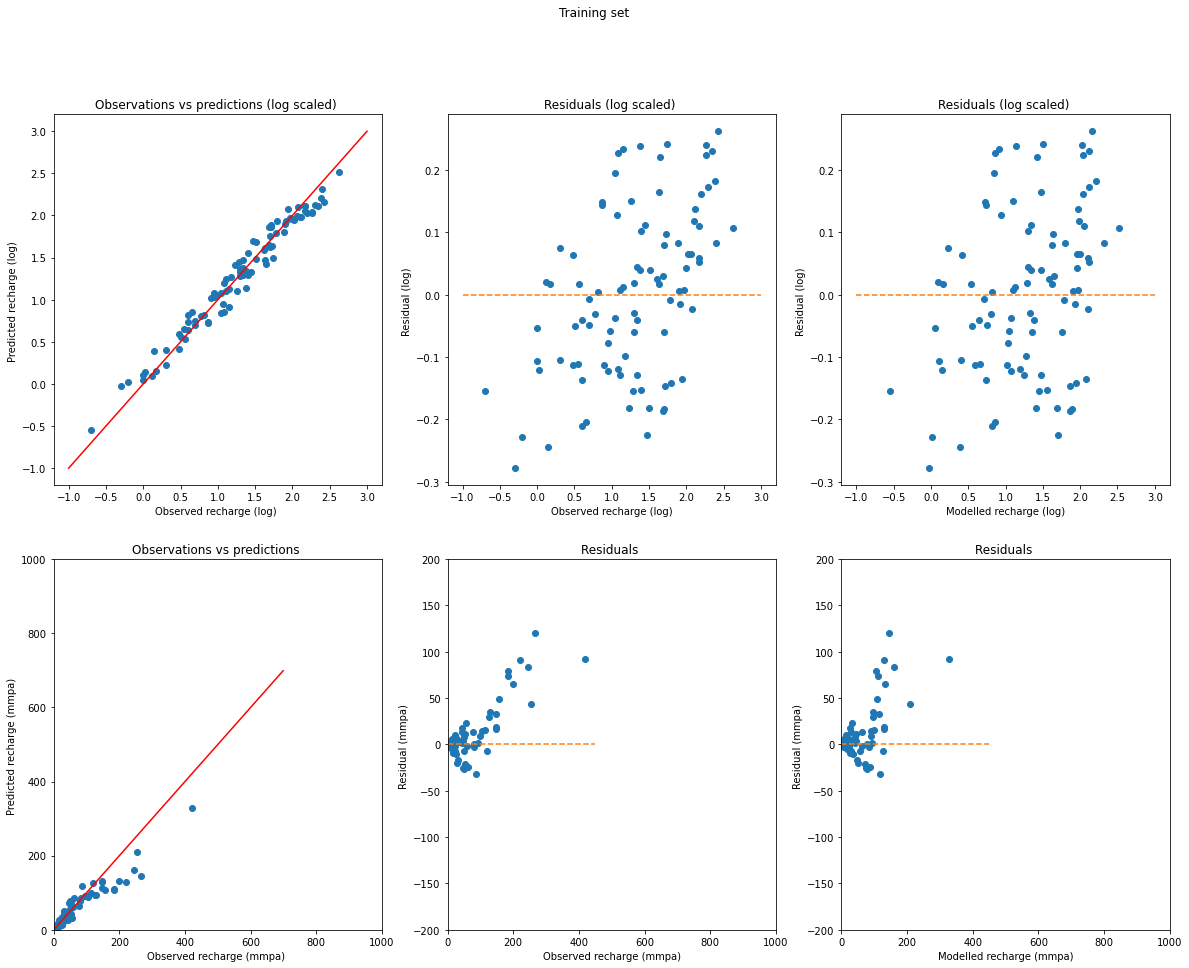

In [17]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(train_labels, train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(train_labels, train_labels - train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(train_predictions, train_labels - train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**train_labels, 10**train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**train_labels, 10**train_labels - 10**train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,450), np.zeros((450,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,1000])
axs[4].set_ylim([-200,200])

axs[5].plot(10**train_predictions, 10**train_labels - 10**train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,450), np.zeros((450,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,1000])
axs[5].set_ylim([-200,200])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

In [18]:
# testing set metrics
print('=== Prediction of testing set ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(test_labels, predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(test_labels, predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, predictions))
print('Max Error:', metrics.max_error(test_labels, predictions))
print('Median Absolute Error:', metrics.median_absolute_error(test_labels, predictions))
print('R^2:', metrics.r2_score(test_labels, predictions))

=== Prediction of testing set ===
Mean Absolute Error (MAE): 0.3729285090023956
Mean Squared Error (MSE): 0.22884202262616254
Root Mean Squared Error (RMSE): 0.4783743540640139
Mean Absolute Percentage Error (MAPE): 0.3631572684059546
Explained Variance Score: 0.6304528091480504
Max Error: 1.167566663630685
Median Absolute Error: 0.2798143780072735
R^2: 0.5553822592883264


(-200.0, 200.0)

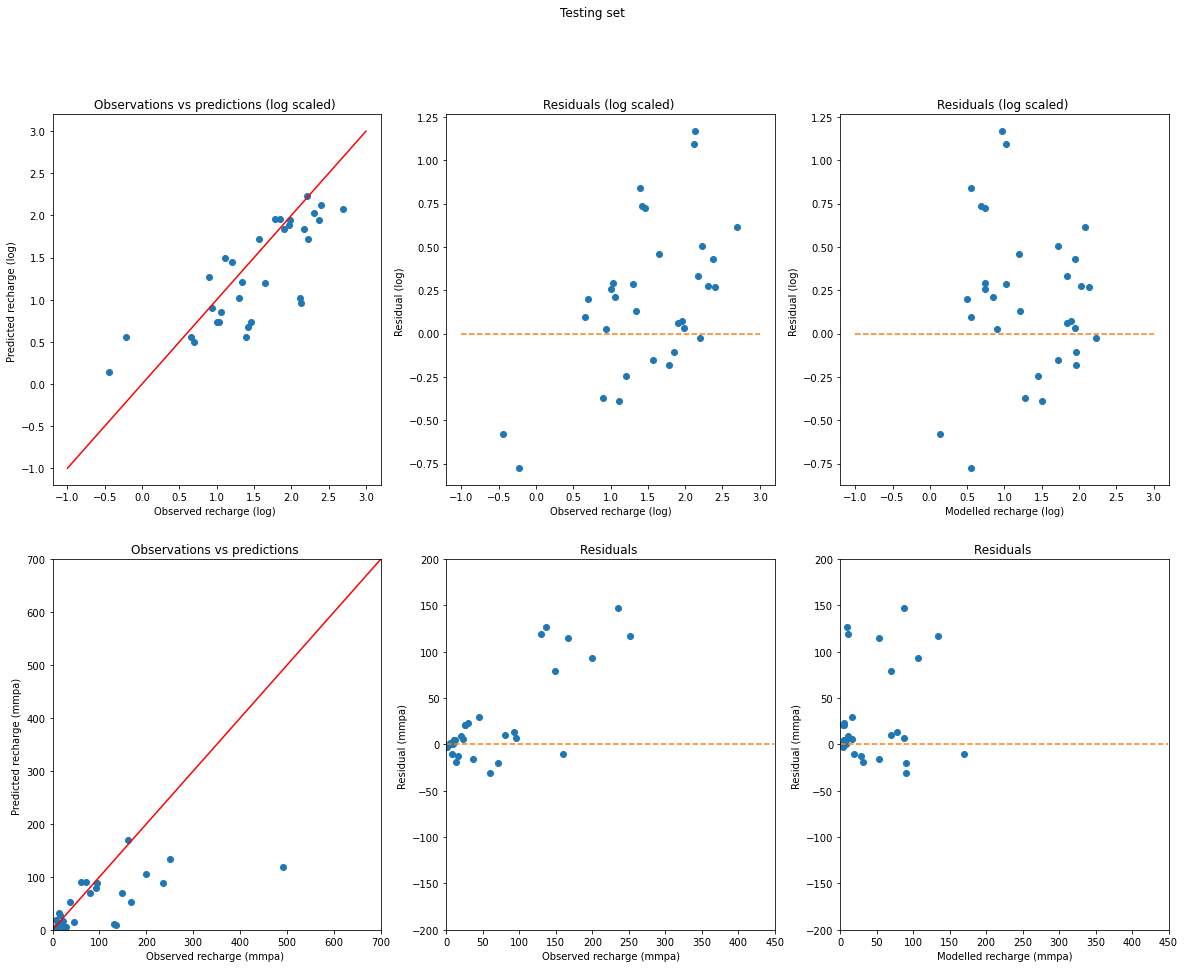

In [19]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(test_labels, predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(test_labels, test_labels - predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(predictions, test_labels - predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**test_labels, 10**predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,700])
axs[3].set_ylim([0,700])

axs[4].plot(10**test_labels, 10**test_labels - 10**predictions,marker='o',linestyle='')
axs[4].plot(range(0,450), np.zeros((450,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,450])
axs[4].set_ylim([-200,200])

axs[5].plot(10**predictions, 10**test_labels - 10**predictions,marker='o',linestyle='')
axs[5].plot(range(0,450), np.zeros((450,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,450])
axs[5].set_ylim([-200,200])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

## Feature importance analysis

In [20]:
# Get numerical feature importances
importances = list(xgbreg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Aridity              Importance: 0.18000000715255737
Variable: LTA_P_mmpa           Importance: 0.10000000149011612
Variable: SM10_kgm2            Importance: 0.09000000357627869
Variable: Soil_group_CL        Importance: 0.05000000074505806
Variable: Soil_group_FL        Importance: 0.03999999910593033
Variable: Soil_group_GL        Importance: 0.03999999910593033
Variable: Soil_group_KS        Importance: 0.03999999910593033
Variable: LTA_WD_days          Importance: 0.029999999329447746
Variable: LTA_PET_mm           Importance: 0.029999999329447746
Variable: DEM                  Importance: 0.029999999329447746
Variable: Soil_group_AR        Importance: 0.029999999329447746
Variable: Soil_group_CM        Importance: 0.029999999329447746
Variable: Soil_group_RG        Importance: 0.029999999329447746
Variable: NDVI                 Importance: 0.019999999552965164
Variable: Aquifer_group_Basement Importance: 0.019999999552965164
Variable: Aquifer_group_Unconsolidated Import

In [21]:
#best_model.get_score()

# Random Forest: second run
Total dataset size: 134 samples <br>
Training set: 100 samples <br>
Testing set: 34 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- LTA NDVI
- DEM
- LTA soil moisture - 10cm (kgm-2)

In [22]:
# Extract the two most important features
important_indices = [feature_list.index('LTA_P_mmpa'), feature_list.index('LTA_WD_days'),
                     feature_list.index('LTA_PET_mm'), feature_list.index('Aridity'), 
                     feature_list.index('NDVI'), feature_list.index('DEM'), feature_list.index('SM10_kgm2')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# New random forest with only the two most important variables
rf_most_important = xgb.XGBRFRegressor(random_state=42, n_estimators=500).fit(train_important, train_labels)
#rf_most_important = xgb.XGBRegressor(n_estimators=50, **params)

In [23]:
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions
predictions = rf_most_important.predict(test_important)
# Make predictions of the training set
train_predictions = rf_most_important.predict(train_important)

/home/anna/anaconda3/envs/gee/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [24]:
print('=== Training set metrics ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(train_labels, train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(train_labels, train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(train_labels, train_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(train_labels, train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, train_predictions))
print('Max Error:', metrics.max_error(train_labels, train_predictions))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(train_labels, train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(train_labels, train_predictions))
print('R^2:', metrics.r2_score(train_labels, train_predictions))
#print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(train_labels, train_predictions))

=== Training set metrics ===
Mean Absolute Error (MAE): 0.11027683234662329
Mean Squared Error (MSE): 0.017373671523736072
Root Mean Squared Error (RMSE): 0.13180922397061623
Mean Absolute Percentage Error (MAPE): 6348917072395.076
Explained Variance Score: 0.9657237119184338
Max Error: 0.2564503370066688
Median Absolute Error: 0.10627244060547636
R^2: 0.9657019028213056


(-200.0, 200.0)

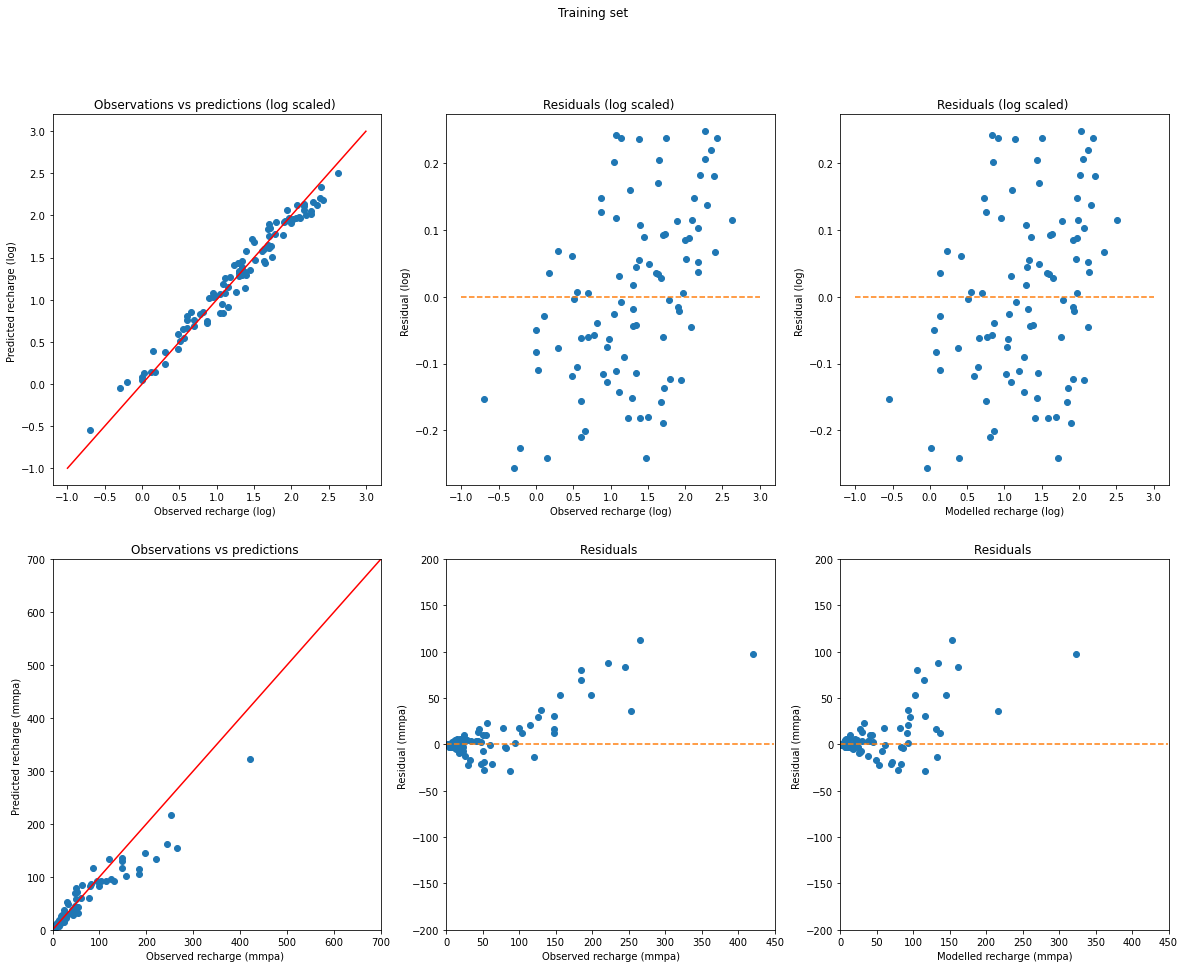

In [25]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(train_labels, train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(train_labels, train_labels - train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(train_predictions, train_labels - train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**train_labels, 10**train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,700])
axs[3].set_ylim([0,700])

axs[4].plot(10**train_labels, 10**train_labels - 10**train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,450), np.zeros((450,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,450])
axs[4].set_ylim([-200,200])

axs[5].plot(10**train_predictions, 10**train_labels - 10**train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,450), np.zeros((450,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,450])
axs[5].set_ylim([-200,200])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

In [26]:
print('=== Testing set metrics ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_labels, predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_labels, predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(test_labels, predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(test_labels, predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, predictions))
print('Max Error:', metrics.max_error(test_labels, predictions))
print('Median Absolute Error:', metrics.median_absolute_error(test_labels, predictions))
print('R^2:', metrics.r2_score(test_labels, predictions))

=== Testing set metrics ===
Mean Absolute Error (MAE): 0.36781211440542794
Mean Squared Error (MSE): 0.2071975140888036
Root Mean Squared Error (RMSE): 0.4551895364447689
Mean Absolute Percentage Error (MAPE): 0.3302048936101015
Explained Variance Score: 0.657044951980023
Max Error: 1.0870412057716456
Median Absolute Error: 0.296199666961047
R^2: 0.5974354293060382


(-200.0, 200.0)

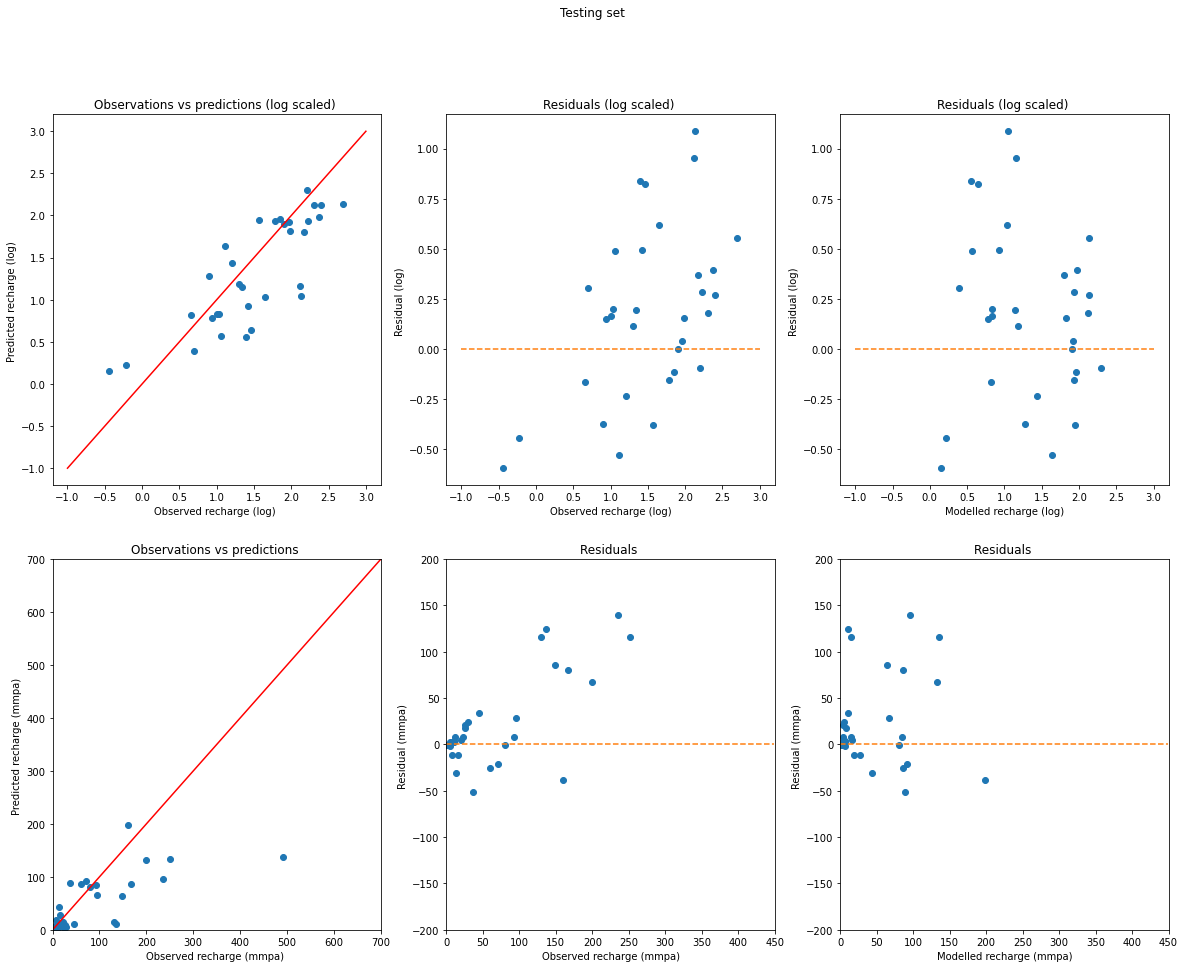

In [27]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(test_labels, predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(test_labels, test_labels - predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(predictions, test_labels - predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**test_labels, 10**predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,700])
axs[3].set_ylim([0,700])

axs[4].plot(10**test_labels, 10**test_labels - 10**predictions,marker='o',linestyle='')
axs[4].plot(range(0,450), np.zeros((450,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,450])
axs[4].set_ylim([-200,200])

axs[5].plot(10**predictions, 10**test_labels - 10**predictions,marker='o',linestyle='')
axs[5].plot(range(0,450), np.zeros((450,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,450])
axs[5].set_ylim([-200,200])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])